In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas
from openai import OpenAI
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import openAI to query chatGPT within notebook
with open('/content/drive/MyDrive/apikey.txt', 'r') as f:
    openai_api_key = f.read().strip()

client = OpenAI(
    api_key=openai_api_key
)

# enable text wrapping in output cells
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
file_path = '/content/drive/MyDrive/senator_twitter_May-Oct.csv'
tweet_df = pd.read_csv(file_path)

tweet_df.head(5)

,Unnamed: 0.1,Unnamed: 0,tweet_id,time,text,replies,retweets,likes,from_user,from_content,twitter_id,name,state,party,gender,birth,age
0,4014,37,1322145371108331520,2020-10-30 11:56:35,More jobs. More investment. More economic oppo...,40,24,143,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
1,4015,38,1321926867696390144,2020-10-29 21:28:20,Marty and I are excited to be back on the camp...,46,26,107,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
2,4016,39,1321906471244845061,2020-10-29 20:07:17,ICYMI: Gov. Kemp announces 46 people snared in...,24,30,174,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
3,4017,40,1321517100398268416,2020-10-28 18:20:03,I promised that Georgia would stop and dismant...,29,37,173,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
4,4018,41,1321478513988423680,2020-10-28 15:46:44,"Now or on November 3rd, vote for the political...",88,35,159,Kelly Loeffler,We are now less than a week away from the most...,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57


In [3]:
# create metadata df
governor_df = tweet_df[['name', 'state', 'party', 'gender', 'age',]].drop_duplicates()
governor_df = governor_df.reset_index(drop=True)
governor_df.head(5)

,name,state,party,gender,age
0,Brian Kemp,GA,Republican,Male,57
1,Doug Burgum,ND,Republican,Male,64
2,Doug Ducey,AZ,Republican,Male,56
3,Gavin Newsom,CA,Democratic,Male,53
4,Gina Raimondo,RI,Democratic,Female,49


In [4]:
# get 1 row per state + governor and their corresponding party
grouped = tweet_df.groupby(['state','name'])
result = grouped.first().reset_index()
final_df = result[['state', 'name', 'party']]

# get count of tweets per state/governor
tweet_counts = grouped.size()
tweet_counts = tweet_counts.reset_index(name='tweet_count')

# merge governor info + tweet counts into one df
governor_df = pd.merge(governor_df, tweet_counts, on=['state', 'name'], how='left')
governor_df.head(5)

,name,state,party,gender,age,tweet_count
0,Brian Kemp,GA,Republican,Male,57,305
1,Doug Burgum,ND,Republican,Male,64,262
2,Doug Ducey,AZ,Republican,Male,56,1323
3,Gavin Newsom,CA,Democratic,Male,53,512
4,Gina Raimondo,RI,Democratic,Female,49,3


Scatterplot of tweet count

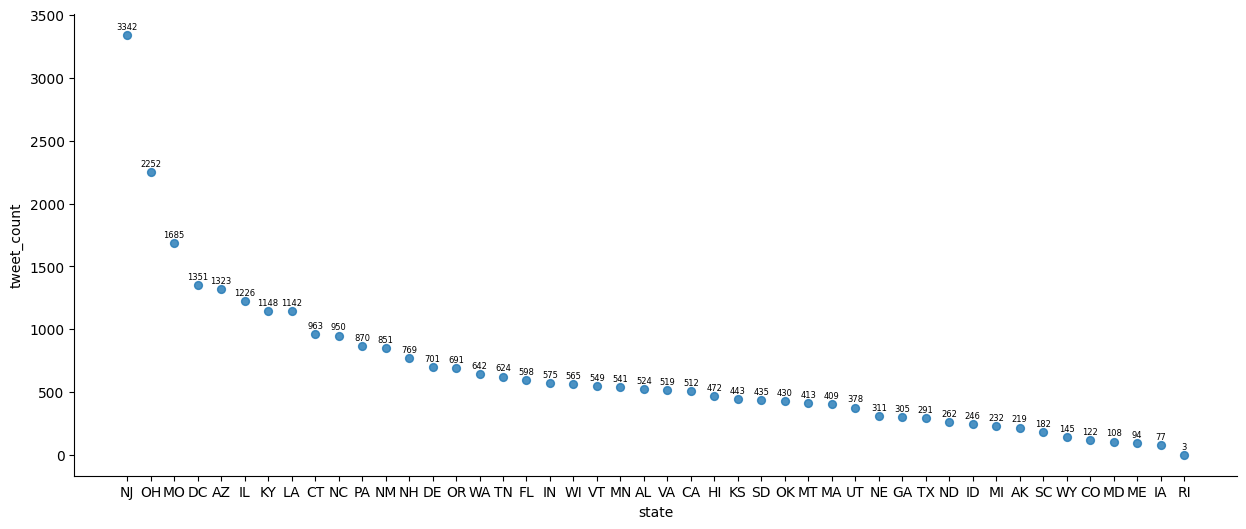

In [5]:
governor_df_sorted = governor_df.sort_values(by='tweet_count', ascending=False)
governor_df_sorted = governor_df_sorted.reset_index(drop=True) # reset index and drop old index
governor_df_sorted.reset_index().plot(kind='scatter', x='state', y='tweet_count', s=32, alpha=.8, figsize=(15, 6))

plt.gca().spines[['top', 'right',]].set_visible(False)

# Add labels with tweet counts
for i, row in governor_df_sorted.iterrows():
    plt.text(row['state'], row['tweet_count']+30, str(row['tweet_count']),
             ha='center', va='bottom', fontsize=6)  # Adjust fontsize as needed


Top 5 most active governors

In [6]:
governor_df_sorted.head(5)

,name,state,party,gender,age,tweet_count
0,Phil Murphy,NJ,Democratic,Male,63,3342
1,Mike DeWine,OH,Republican,Male,73,2252
2,Mike Parson,MO,Republican,Male,65,1685
3,Muriel Bowser,DC,Democratic,Female,48,1351
4,Doug Ducey,AZ,Republican,Male,56,1323


In [7]:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

df_states = governor_df['state'].unique()

# get list of which states are not included
missing_states = [state for state in states if state not in df_states]
extra_states = [state for state in df_states if state not in states]
print("Missing states:", missing_states) # expecting 4 but got 5...
print("Extra \"states\": ", extra_states) # the extra state in our dataset

Missing states: ['AR', 'MS', 'NV', 'NY', 'WV']
Extra "states":  ['DC']


In [8]:
states = geopandas.read_file('/content/drive/MyDrive/us-state-boundaries/us-state-boundaries.shp')
states = states.to_crs(epsg=3395)

# drop non-contiguous states and plot with random color (for now)
contig_48 = states.drop([0,5,21,29,30,31,38,53])

# define party colors
party_colors = {'Democratic': 'lightblue',  'Republican': 'red'}

# merge geodata & governor tweet data into single dataframe
merged_states = contig_48.merge(governor_df, left_on='stusab', right_on='state', how='left')
merged_states['color'] = merged_states['party'].map(party_colors)

# create custom color map based on party affiliation
cmap = ListedColormap(list(party_colors.values()))

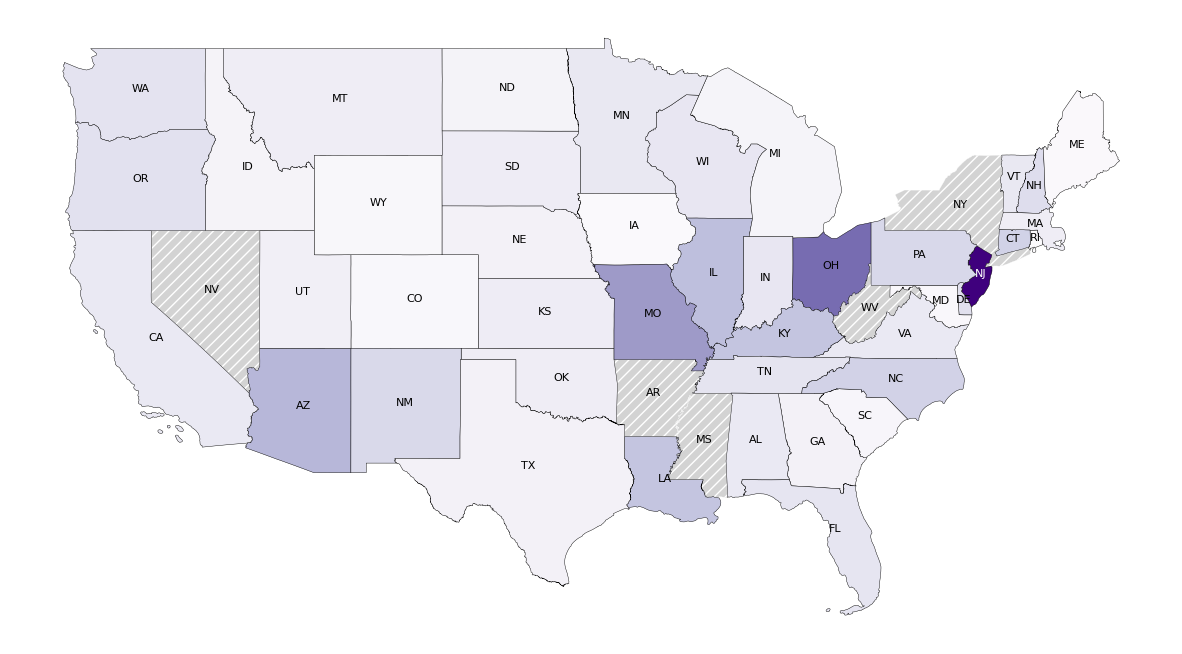

In [9]:
# normalize tweet counts across all senators
scaler = MinMaxScaler()
merged_states['normalized_tweets'] = scaler.fit_transform(merged_states[['tweet_count']])

# plot political party with separate colormaps
fig, ax = plt.subplots(figsize=(15, 10))

# Base layer: all 50 states
contig_48.plot(
    ax=ax,
    color= "lightgrey",
    edgecolor= "white",
    hatch= "///",
    linewidth=0.2
)

# overlay all states with color intensity normalized by tweet count
merged_states.plot(
    ax=ax,
    column='normalized_tweets',
    cmap='Purples',
    edgecolor='black',
    linewidth=0.3
)

# include state labels
for idx, row in merged_states.iterrows():
    # Get centroid coordinates
    centroid = row['geometry'].centroid

    # handle case where centroid is point
    if centroid.geom_type == 'Point':
        x, y = centroid.coords[0]
    # handle other geometry types
    else:
        x, y = centroid.x, centroid.y

    if row['stusab'] == 'NJ':
      ax.text(x+15000, y, row['stusab'], fontsize=8, ha='center', color='white')
    else:
      ax.text(x, y, row['stusab'], fontsize=8, ha='center', color='black')


ax.set_axis_off()
plt.show()

Plot frequency of tweets normalized within each political party

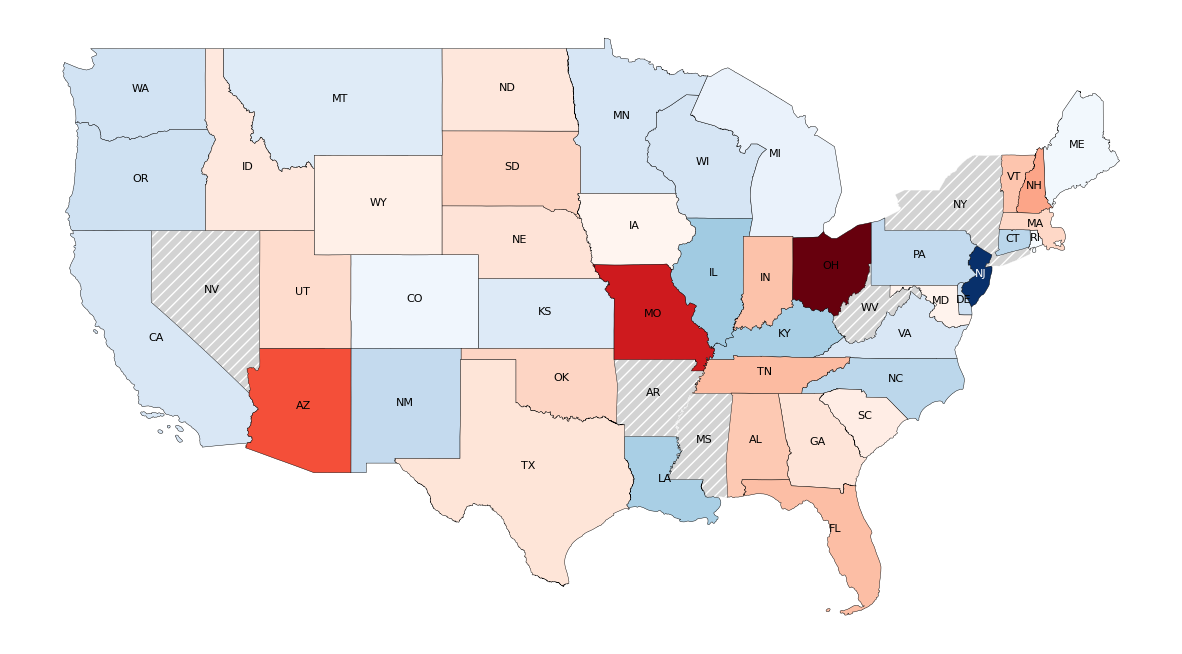

In [10]:
# create separate normalized tweet columns for Democrats and Republicans
democrat_states = merged_states[merged_states['party'] == 'Democratic']
democrat_states['normalized_tweets'] = scaler.fit_transform(democrat_states[['tweet_count']])

republican_states = merged_states[merged_states['party'] == 'Republican']
republican_states['normalized_tweets'] = scaler.fit_transform(republican_states[['tweet_count']])

# plot political party with separate colormaps
fig, ax = plt.subplots(figsize=(15, 10))

# base layer: all 50 states
contig_48.plot(
    ax=ax,
    color= "lightgrey",
    edgecolor= "white",
    hatch= "///",
    linewidth=0.2
)

# overlay democrat & republican states
democrat_states.plot(
    ax=ax,
    column='normalized_tweets',
    cmap='Blues',
    edgecolor='black',
    linewidth=0.3
)

republican_states.plot(
    ax=ax,
    column='normalized_tweets',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.3
)

# include state labels
for idx, row in merged_states.iterrows():
    # Get centroid coordinates
    centroid = row['geometry'].centroid

    # handle case where centroid is point
    if centroid.geom_type == 'Point':
        x, y = centroid.coords[0]
    # handle other geometry types
    else:
        x, y = centroid.x, centroid.y

    if row['stusab'] == 'NJ':
      ax.text(x+15000, y, row['stusab'], fontsize=8, ha='center', color='white')
    else:
      ax.text(x, y, row['stusab'], fontsize=8, ha='center', color='black')

ax.set_axis_off()
plt.show()

Things of note
*   Missing states: 'AR', 'MS', 'NV', 'NY', 'WV'
*   Extra states: 'DC'
* Democratic governor with the most tweets: Phil Murphy (NJ)
* Republican governor with the most tweets: Mike DeWine (OH)



Check if any of the given politicians were senators in 2020

In [11]:
all_governors = list(governor_df_sorted['name'].unique())

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{
      "role": "user",
      "content": f"Were any of the following {all_governors} U.S. senators in 2020? Was he/she ever a senator of the United States?"}
])

print(response.choices[0].message.content)

As of 2020, none of the individuals listed were U.S. senators. All of them served as governors of their respective states or held other positions, but they were not serving as U.S. senators at that time. Some of them may have held other political office in the past, but none were U.S. senators during 2020.


Who is the mystery person from DC who snuck into our dataset?

In [12]:
outlier = governor_df.loc[governor_df['state'] == 'DC', 'name'].values[0]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{
      "role": "user",
      "content": f"Who is {outlier}? Was he/she ever a governor of the United States?"}
])

print(response.choices[0].message.content)

Muriel Bowser is a politician who serves as the Mayor of Washington, D.C. She took office on January 2, 2015. Bowser is a member of the Democratic Party and previously served on the D.C. Council, representing the 4th ward.

She has never served as a governor of any U.S. state, as Washington, D.C. is a federal district and does not have a governor. Instead, the mayor of D.C. serves as the chief executive of the district.


*   Drop all tweets by Muriel Bowser (maybe)
*   Calculate average time between tweets for each governor




In [13]:
# calculate average time between tweets
# assuming each gov has at least 2 tweets
def calculate_avg_time_between_tweets(df, governor_name):
  governor_tweets = df[df['name'] == governor_name]
  governor_tweets = governor_tweets.sort_values(by=['time'], ascending=True)

  governor_tweets['time_diff'] = pd.to_datetime(governor_tweets['time']).diff()
  average_time_diff = governor_tweets['time_diff'].mean()
  average_time_diff = average_time_diff.total_seconds() / (60 * 60)
  return average_time_diff


results = []

# iterate over all governors in our dataset
for gov in all_governors:
  avg_time = calculate_avg_time_between_tweets(tweet_df, gov)
  results.append({
      'name': gov,
      'avg_time_bw_tweets': avg_time
  })

# create df from results
avg_time_df = pd.DataFrame(results).sort_values(by='avg_time_bw_tweets', ascending=False)
governor_df = governor_df.merge(avg_time_df, on='name', how='left') # merge into metadata df
avg_time_df.head(5)

,name,avg_time_bw_tweets
45,Gina Raimondo,1103.258333
44,Kim Reynolds,57.772767
42,Larry Hogan,40.697991
43,Janet Mills,39.161989
41,Jared Polis,35.875562


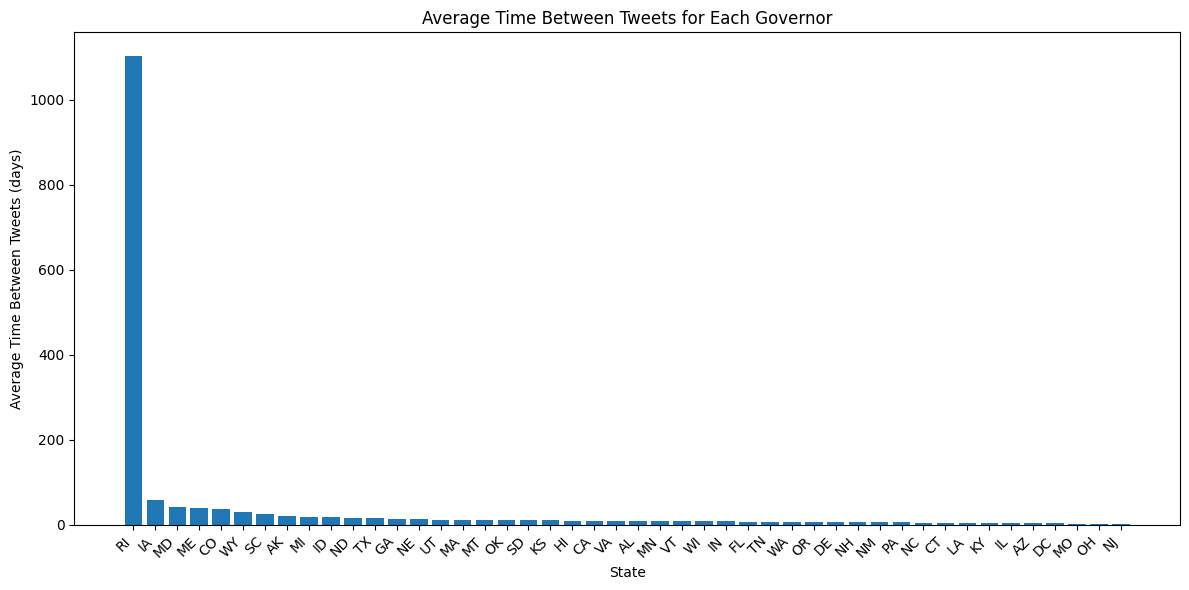

In [14]:
time_df = governor_df.sort_values(by=['avg_time_bw_tweets'], ascending=False)

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(time_df['state'], time_df['avg_time_bw_tweets'])

# Customize the chart
plt.xlabel("State")
plt.ylabel("Average Time Between Tweets (days)")
plt.title("Average Time Between Tweets for Each Governor")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the chart
plt.show()


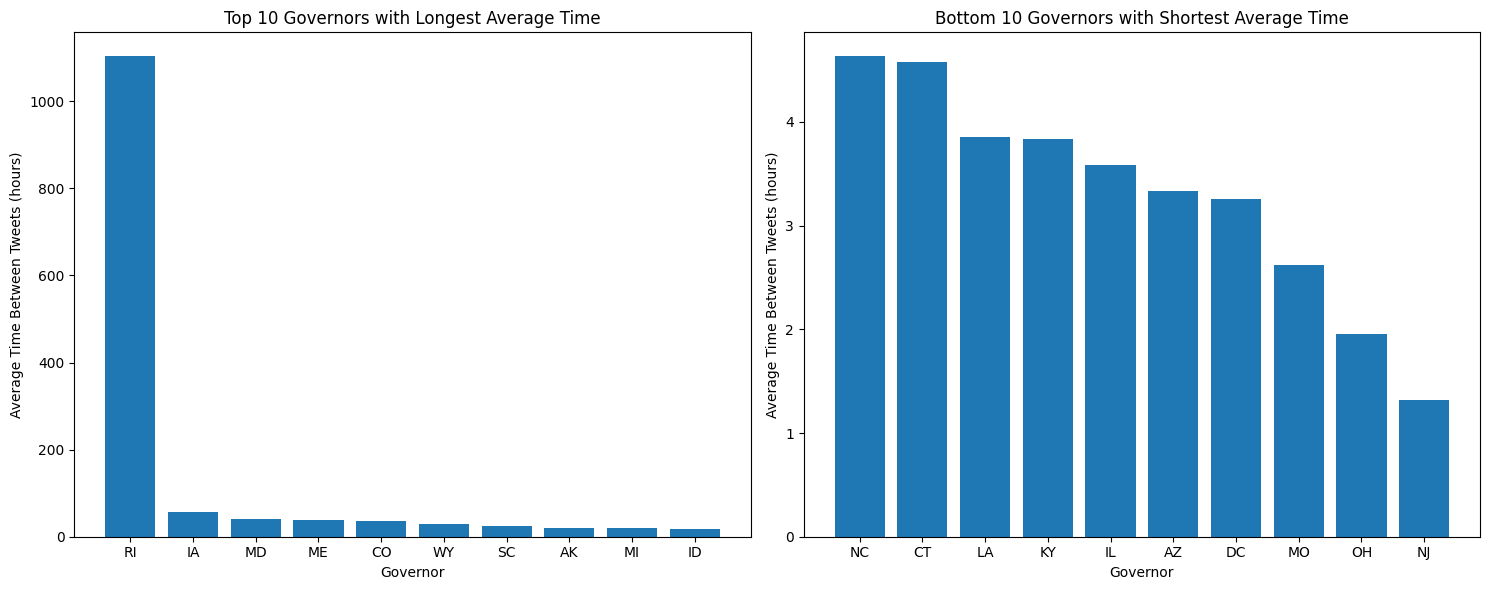

In [15]:
# Get the top 10 and bottom 10 governors
top_10 = time_df.head(10)
bottom_10 = time_df.tail(10)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the top 10
ax1.bar(top_10['state'], top_10['avg_time_bw_tweets'])
ax1.set_xlabel("Governor")
ax1.set_ylabel("Average Time Between Tweets (hours)")
ax1.set_title("Top 10 Governors with Longest Average Time")
ax1.tick_params(axis='x')

# Plot the bottom 10
ax2.bar(bottom_10['state'], bottom_10['avg_time_bw_tweets'])
ax2.set_xlabel("Governor")
ax2.set_ylabel("Average Time Between Tweets (hours)")
ax2.set_title("Bottom 10 Governors with Shortest Average Time")
ax2.tick_params(axis='x')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Incorporate external dataset related to 2020 Election Results: https://www.kaggle.com/datasets/tunguz/us-elections-dataset

In [16]:
election_df = pd.read_csv('/content/drive/MyDrive/1976-2020-president.csv')
election_df = election_df[election_df['year'] == 2020]
election_df.head(5)

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3740,2020,ALABAMA,AL,1,63,41,US PRESIDENT,"BIDEN, JOSEPH R. JR",DEMOCRAT,False,849624,2323282,20210113,NaN,DEMOCRAT
3741,2020,ALABAMA,AL,1,63,41,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,1441170,2323282,20210113,NaN,REPUBLICAN
3742,2020,ALABAMA,AL,1,63,41,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,25176,2323282,20210113,NaN,LIBERTARIAN
3743,2020,ALABAMA,AL,1,63,41,US PRESIDENT,NaN,NaN,True,7312,2323282,20210113,NaN,OTHER
3744,2020,ALASKA,AK,2,94,81,US PRESIDENT,"BIDEN, JOSEPH R. JR",DEMOCRAT,False,153778,359530,20210113,NaN,DEMOCRAT


In [17]:
agg_df = election_df.groupby('state_po').agg(
    total_votes=('candidatevotes', 'sum'),
    dem_votes=('candidatevotes', lambda x: x[election_df['party_simplified'] == 'DEMOCRAT'].sum()),  # Democratic votes
    rep_votes=('candidatevotes', lambda x: x[election_df['party_simplified'] == 'REPUBLICAN'].sum()),   # Republican votes
    oth_votes=('candidatevotes', lambda x: x[~election_df['party_simplified'].isin(['DEMOCRAT','REPUBLICAN'])].sum())   # other votes
  )

agg_df.reset_index(inplace=True)
agg_df = agg_df.rename(columns={'state_po': 'state'})

# calculate proportion of votes for each cateogry
agg_df['dem_pct'] = agg_df['dem_votes'] / agg_df['total_votes']
agg_df['rep_pct'] = agg_df['rep_votes'] / agg_df['total_votes']
agg_df['oth_pct'] = agg_df['oth_votes'] / agg_df['total_votes']

# assign election winner based off which party had higher proportion of votes
agg_df['winner'] = agg_df.apply(lambda row: 'Democratic' if row['dem_pct'] > row['rep_pct'] else 'Republican', axis=1)

governor_df = governor_df.merge(agg_df[['state', 'total_votes', 'dem_pct', 'rep_pct', 'oth_pct', 'winner']], on='state', how='left') # merge into governor_df
governor_df.head(5)

,name,state,party,gender,age,tweet_count,avg_time_bw_tweets,total_votes,dem_pct,rep_pct,oth_pct,winner
0,Brian Kemp,GA,Republican,Male,57,305,14.271598,4999960,0.494731,0.492375,0.012895,Democratic
1,Doug Burgum,ND,Republican,Male,64,262,16.755047,361819,0.317568,0.651140,0.031292,Republican
2,Doug Ducey,AZ,Republican,Male,56,1323,3.337105,3387326,0.493647,0.490560,0.015793,Democratic
3,Gavin Newsom,CA,Democratic,Male,53,512,8.632366,17500881,0.634839,0.343207,0.021953,Democratic
4,Gina Raimondo,RI,Democratic,Female,49,3,1103.258333,516990,0.594762,0.386704,0.018534,Democratic


Can also get average engagement (likes, retweets, replies) per tweet for each governor
Then run regression analysis